
# Multi CoMoment SEM (MCMSEM)

This `R` notebook is associated with the preprint “link” and github repo in which I (Michel Nivard), together with colleagues outline three feasible ways for causal inference in latent explanatory models in psychological science. The goal is to highlight how techniques from across diciplines can be used to identify (network) models, which have been key features of psychological theory at least since 2006, in the context of SEM.

There are two other notebooks outlining two alternate techniques. This notebook outlines the use of MCMSEM, a structural equation model that jointly models the covariance, coskewness and cokurtosis of the data. Refer to the repo and pre-print for statistical details, consult the MCMSEM github for detials on specifying and running models. <ins data-op-user-id="" data-op-user-nickname="" data-op-date="1734953880000"> isnt this cool?</ins>


In [ ]:
Sys.setenv(CUDA="11.7")

Lets load the required packages, if you are running this in google colab these first few chucks might take a while so grab some tea/coffee while it loads.(26 minutes for me)


In [ ]:
install.packages("remotes")library(remotes)install_github("https://github.com/zenabtamimy/MCMSEM",ref = "dev-torch")library(MCMSEM)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'MCMSEM' from a github remote, the SHA1 (06affa30) has not changed since last install.
  Use `force = TRUE` to force installation



# Simulate data

Like in the notebooks describing the other techniques we begin by simulating data. The deveopmental version of the MCMSEM packages has simulation code built in. We define netowrk adges (matrix b) and shape/df parameters for the variables. if shape = 0 a t-distribution is drawn, if shape is > 0 (but integer) a gamma distribution is drawn.

the network edges are chosen such that we get 5 correlate variables with reasnably high and similar pairwise correlations. This kind of data is in psychological sciences frequently modeled with a latent variable. In this case its derived from a network. We then try to estimate/retrieve the network parameters accurately with MCMSEM.


In [ ]:
set.seed(123)n <- 30000b <- matrix(c(   0,  .22,   0,  .24,  .35,  # The network weights (bidirectional regression paths between endogeneous variables y1 to y5)                 0,   0,   .15,  .31,  .0,                 .35,  .2,   0, -.14,   .3,                 .14, -.2,  .36,   0,   .4,                 0, .30, .15,   -.15,    0), 5,5,byrow=T)# Latent variables don't load on the indicators, its as if they aren't there:a <- matrix(c(0, 0, 0, 0, 0,              0, 0, 0, 0, 0), ncol=2)# use the MCMSEM internal simuation tool:simmdata<- simulate_data(n=n,a=a,b=t(b),shape=c(7, 0, 3, 4, 5), df=c(0, 8, 0, 10, 12),asdataframe = T)

  Note this data simulation is not exact and may contain sampling error.


Warning message in simulate_data(n = n, a = a, b = t(b), shape = c(7, 0, 3, 4, 5), :
“Sampling error is likely worsened by the small sample size”


Lets inspect these simualted data briefly:


In [ ]:
cor(simmdata)

1.0000000,0.5362363,0.6066390,0.5121428,0.5666842
0.5362363,1.0000000,0.6463842,0.3525293,0.6536053
0.6066390,0.6463842,1.0000000,0.5237366,0.6610572
0.5121428,0.3525293,0.5237366,1.0000000,0.4918703
0.5666842,0.6536053,0.6610572,0.4918703,1.0000000


# running MCMSEM

Here I run MCMSEM. note that for illustrative purposes I run the model for 500 iterations of rprop and then 50 using the lbfgs algorirtm, in a real appliction i’d consider anywhere from 3x to 10x that and then evaluate whether the final gredients are (very) small before reporting the results. We’d also need to carefully pick a model appropriate learning rate. All of these are matters of finesse that require trial and error and some experience. Especially the standard errors will suffer from non-convergence but none of the output is to be trusted. As MCMSEM is very general purpose there arent many outomated checks on convergence but the final gratients are reported tot he user.


In [ ]:
mod.network <- MCMmodel(simmdata, n_latent=0,                        causal_observed = T,scale_data = T ,constrained_a = FALSE)res.network <- MCMfit(mod.network , simmdata,                      optimizers=c("rprop", "lbfgs"), optim_iters=c(500,50),                      learning_rate=c(0.15,.75), monitor_grads = TRUE,debug = F)

Warning message in MCMfit(mod.network, simmdata, optimizers = c("rprop", "lbfgs"), :
“Use of a dataframe with more than 2 columns is still experimental.”


Lets look at a summary of the model we rjust estimated:


In [ ]:
summary(res.network)

|--------------------------------------|
| MCM Result Summary (MCMSEM v0.26.1)  |
|--------------------------------------|
device         : cpu
N phenotypes   : 5
N latents      : 0
N observations : 30000
N parameters   : 35
SE type        : asymptotic

Fit statistics
loss  : 0.00519814807921648
chisq : 155.944442376494
BIC   : 516.757785499045

Parameters summary
   label lhs edge rhs          est         se             p
1   b1_2  x1   ~>  x2  0.214321822 0.02091627  1.225101e-24
2   b1_3  x1   ~>  x3 -0.003763729 0.01329152  7.770483e-01
3   b1_4  x1   ~>  x4  0.180262208 0.03057043  3.710209e-09
4   b1_5  x1   ~>  x5  0.222836584 0.02770858  8.827479e-16
5   b2_1  x2   ~>  x1 -0.007043016 0.02190970  7.478645e-01
6   b2_3  x2   ~>  x3  0.172452554 0.01399555  6.900108e-35
7   b2_4  x2   ~>  x4  0.337839603 0.04409928  1.846538e-14
8   b2_5  x2   ~>  x5 -0.017539868 0.04350535  6.868263e-01
9   b3_1  x3   ~>  x1  0.384442985 0.02733692  6.398033e-45
10  b3_2  x3   ~>  x2  0.18456827

Note how all gradiensts displayed are low, lets check if thats true for all parameters that where truncated as well, and then go ahead and inspect a visualisation:


[1] "0.000609114766120911"

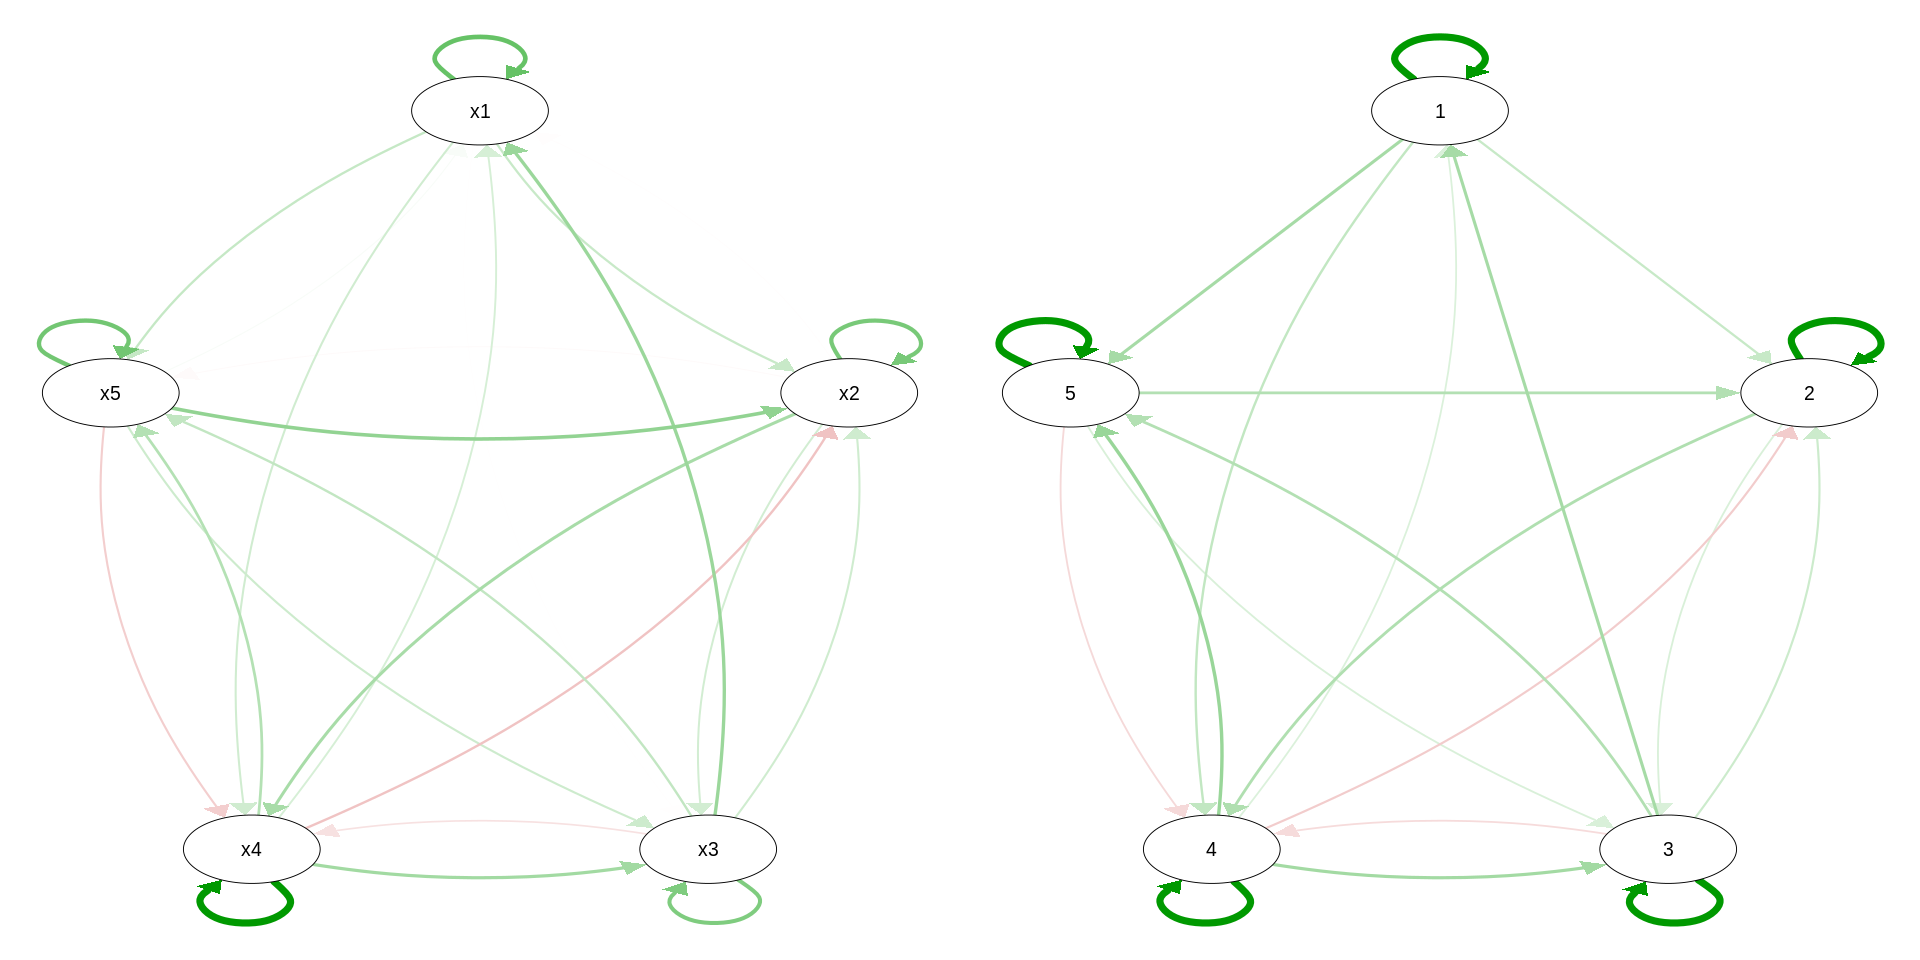

In [ ]:
# inspect the largest gradientmax(as.data.frame(summary(res.network), estimates='parameters')$last_gradient)# Make a plot of the actual and retrieved networks:options(repr.plot.width=16, repr.plot.height=8)par(mfrow=c(1,2), mai=c(1.5,1.5,1.5,1.5))plot(res.network,layout="circle") # estimatedqgraph::qgraph(b + diag(5),diag=T,layout="circle") # aproximately 

largest gradient is small (certainly close enough for a tutorial) and the network resembles what we simulated closely.


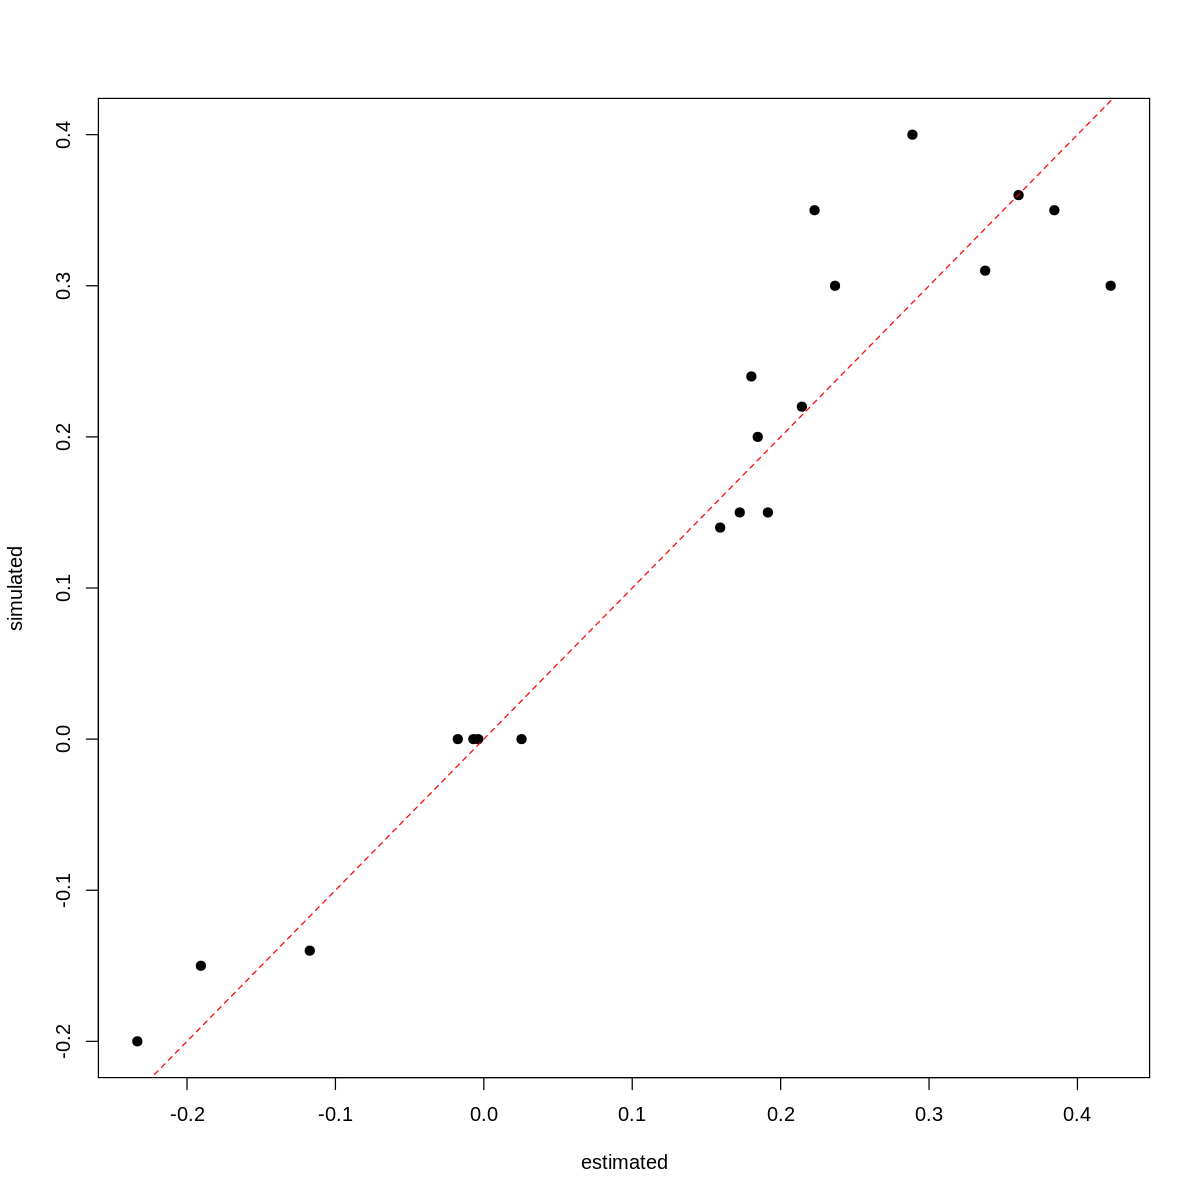

In [ ]:
estimated <- as.numeric(res.network$df[1,1:20])c <- b # get true networkdiag(c) <- NA # omit diagsimulated <- na.omit(as.vector(t(c))) # vectorizeoptions(repr.plot.width=10, repr.plot.height=10)plot(estimated,simulated,pch=19) # plot treu vs estimated pathsabline(0,1,col="red",lty="dashed")

## Adding accomodations for error

So we were able to retreive a (cyclical) network from cross-sectional data using additional moments. We can go further and accomodate variable specific measuremenr error, which need not even be normally distributed! Lets go ahead and simulate that, note I am increasing the sample size quite a bit as we are asking a lot of the data!


In [ ]:
set.seed(123)n <- 80000b <- matrix(c(   0,  .22,   0,  .24,  .35,  # The network weights (bidirectional regression paths between endogeneous variables y1 to y5)                 0,   0,   .15,  .31,  .0,                 .35,  .2,   0, -.14,   .3,                 .14, -.2,  .36,   0,   .4,                 0, .30, .15,   -.15,    0), 5,5,byrow=T)# Latent variables don't load on the indicators, its as if they aren't there:a <- matrix(c(0, 0, 0, 0, 0,              0, 0, 0, 0, 0), ncol=2)# use the MCMSEM internal simuation tool:simmdata<- simulate_data(n=n,a=a,b=t(b),shape=c(7, 0, 3, 4, 5), df=c(0, 8, 0, 10, 12),asdataframe = T)simmdata[,1] <- simmdata[,1] + rnorm(n,0,sqrt(.5)) # add normal error with var = .5 simmdata[,2] <- simmdata[,2] + rnorm(n,0,sqrt(.5)) # add normal error with var = .5 simmdata[,3] <- simmdata[,3] + sqrt(.5)*scale(rt(n,df=7)) # add t-dist error with var = .5 simmdata[,4] <- simmdata[,4] + rnorm(n,0,sqrt(.5)) # add normal error with var = .5 simmdata[,5] <- simmdata[,5] + sqrt(.5)*scale(rchisq(n,df=7)) # add chisq error with var = .5 

  Note this data simulation is not exact and may contain sampling error.


Warning message in simulate_data(n = n, a = a, b = t(b), shape = c(7, 0, 3, 4, 5), :
“Sampling error is likely worsened by the small sample size”


In [ ]:
cor(simmdata)

1.0000000,0.4188786,0.4707920,0.3995633,0.4672741
0.4188786,1.0000000,0.5167920,0.2827746,0.5512439
0.4707920,0.5167920,1.0000000,0.4146114,0.5567201
0.3995633,0.2827746,0.4146114,1.0000000,0.4114610
0.4672741,0.5512439,0.5567201,0.4114610,1.0000000


And lets also adopt the model to cope. I set up a basic model using MCMmodel (see the MCMSEM github for details and tutorials) and them edit in or out aditional parameters (freeing some, setting others to 0).


In [ ]:
errornet <- MCMmodel(simmdata,n_latent = 5,constrained_a = F,scale_data = T,causal_observed = F,causal_latent = T,skew_latent = T,skew_observed = T,kurt_latent = T,kurt_observed = T,var_latent = F)# Free the variance on 5 latent variables (on for each observed):errornet <- MCMedit(errornet, pointer="S", list(1:5,1:5), c("sl1","sl2","sl3","sl4","sl5"))errornet <- MCMedit(errornet, pointer="S", list(6:10,6:10), c("s1","s2","s3","s4","s5"))# All cross loading to 0:errornet <- MCMedit(errornet, pointer="A", c("a1_2","a1_3","a1_4","a1_5"), 0)errornet <- MCMedit(errornet, pointer="A", c("a2_3","a2_4","a2_5"), 0)errornet <- MCMedit(errornet, pointer="A", c("a3_4","a3_5"), 0)errornet <- MCMedit(errornet, pointer="A", c("a4_5"), 0)# Except for "diagonal" loadings which are 1, so each latent m,asp to a specific observed variable:errornet <- MCMedit(errornet, pointer="A", list(6:10,1:5),c(1,1,1,1,1))model.fit.errornet <- MCMfit(errornet,simmdata,compute_se = T,debug = T,use_kurtosis = T,optim_iters = c(800,50),optimizers = c('rprop','lbfgs'),learning_rate = c(0.1,.35),loss_type = "mse")

MCMfit verifying input
MCMfit converting data


Warning message in MCMfit(errornet, simmdata, compute_se = T, debug = T, use_kurtosis = T, :
“Use of a dataframe with more than 2 columns is still experimental.”


MCMfit transferring co-moments
MCMfit generating torch matrices
MCMfit starting fit:
 - Optimizer=rprop, lr=0.1
  * iter:800 - loss: 0.0448720715939999           
 - Optimizer=lbfgs, lr=0.35
  * iter:50 - loss: 0.000918506644666195           
 - Stacking radient history
MCMfit fit output
MCMfit starting SE calculation:
 - Reformatting parameters for jacobian
 - Reformatting masks for jacobian
 - Calculating jacobian
 - Calculating Asycov
MCMfit formatting output


lets again inspect the model:


In [ ]:
summary(model.fit.errornet)

|--------------------------------------|
| MCM Result Summary (MCMSEM v0.26.1)  |
|--------------------------------------|
device         : cpu
N phenotypes   : 5
N latents      : 5
N observations : 80000
N parameters   : 50
SE type        : asymptotic

Fit statistics
loss  : 0.000917215016670525
chisq : 73.377201333642
BIC   : 637.866297016443

Parameters summary
    label lhs edge rhs         est         se            p
1  bl1_l2  f1   ~>  f2  0.11069144 0.02071056 9.057356e-08
2  bl1_l3  f1   ~>  f3 -0.00290240 0.01572845 8.535963e-01
3  bl1_l4  f1   ~>  f4  0.19809486 0.02896987 8.032826e-12
4  bl1_l5  f1   ~>  f5  0.22142653 0.03281142 1.494229e-11
5  bl2_l1  f2   ~>  f1  0.05686105 0.02595556 2.847296e-02
6  bl2_l3  f2   ~>  f3  0.14630489 0.05338439 6.132837e-03
7  bl2_l4  f2   ~>  f4  0.29191372 0.09876097 3.118998e-03
8  bl2_l5  f2   ~>  f5 -0.02339981 0.04435800 5.978314e-01
9  bl3_l1  f3   ~>  f1  0.33524403 0.03011105 8.609854e-29
10 bl3_l2  f3   ~>  f2  0.17165019 0.022956

Note that the final gradients are kind of large for some parameters, we’d like them a little lower probably if this was an emperical analysis. Nevertheless lets inspect the retrieved network:


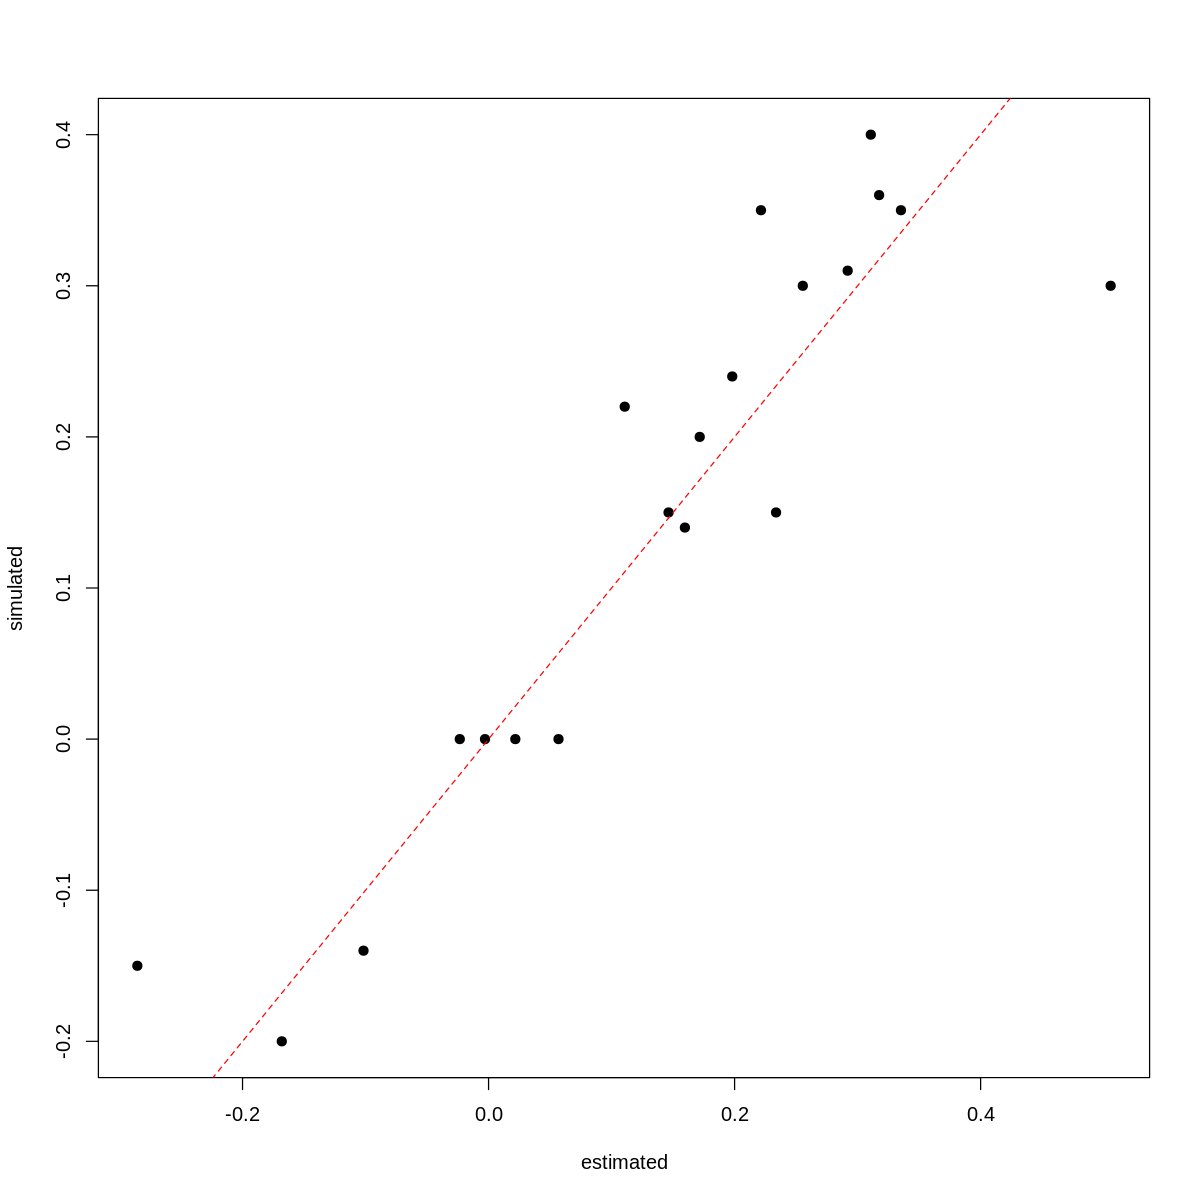

In [ ]:
estimated <- as.numeric(model.fit.errornet$df[1,1:20])c <- b # get true networkdiag(c) <- NA # omit diagsimulated <- na.omit(as.vector(t(c))) # vectorizeoptions(repr.plot.width=10, repr.plot.height=10)plot(estimated,simulated,pch=19) # plot true vs estimated pathsabline(0,1,col="red",lty="dashed")

The limits to the degree to which the residual influences can absorb non-normality, and the power requirements are an active area of study (some help out!). If you want to follow up with 2 further techniques for causla inferences trough systematic constraint in SEM go to our github repo.
